In [1]:
import re
import pandas as pd
import numpy as np
import sacrebleu
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


# A dictionary to hold our data: {sentence_id: {"ref": "...", "hypo": "..."}}
translations = {}

# The file generated by `fairseq-generate`
input_file = "inference_output90_11.txt"


In [2]:

with open(input_file, 'r', encoding='utf-8') as f:
    for line in f:
        # We only care about the detokenized hypothesis (D) and target (T)
        if line.startswith('T-'):
            parts = line.strip().split('\t')
            sent_id = parts[0].split('-')[1]
            if sent_id not in translations:
                translations[sent_id] = {}
            translations[sent_id]['ref'] = parts[1]

        elif line.startswith('D-'):
            parts = line.strip().split('\t')
            sent_id = parts[0].split('-')[1]
            if sent_id not in translations:
                translations[sent_id] = {}
            # We use the score from the D- line, and the text
            translations[sent_id]['score'] = float(parts[1])
            translations[sent_id]['hypo'] = parts[2]


--- Step 1: Parsing Log File ---
Parsing complete. Found stats for 2000 sentences and translations for 2000 sentences.

--- Step 2: Aggregating k-NN Stats per Sentence ---
Aggregated diagnostic stats for 2000 sentences.

--- Step 3: Assembling Final DataFrame ---
Successfully created DataFrame with 8000 total hypotheses.
   sent_id  beam_index  bleu_score   p4  avg_fraction_old  avg_prob_mass_old
0      175           0    50.00000  0.0          0.072215           0.192155
1      175           1    50.00000  0.0          0.072215           0.192155
2      175           2    27.51606  0.0          0.072215           0.192155
3      175           3    50.00000  0.0          0.072215           0.192155
4      581           0     0.00000  0.0          0.045555           0.241760
5      581           1     0.00000  0.0          0.045555           0.241760
6      581           2     0.00000  0.0          0.045555           0.241760
7      581           3     0.00000  0.0          0.045555    

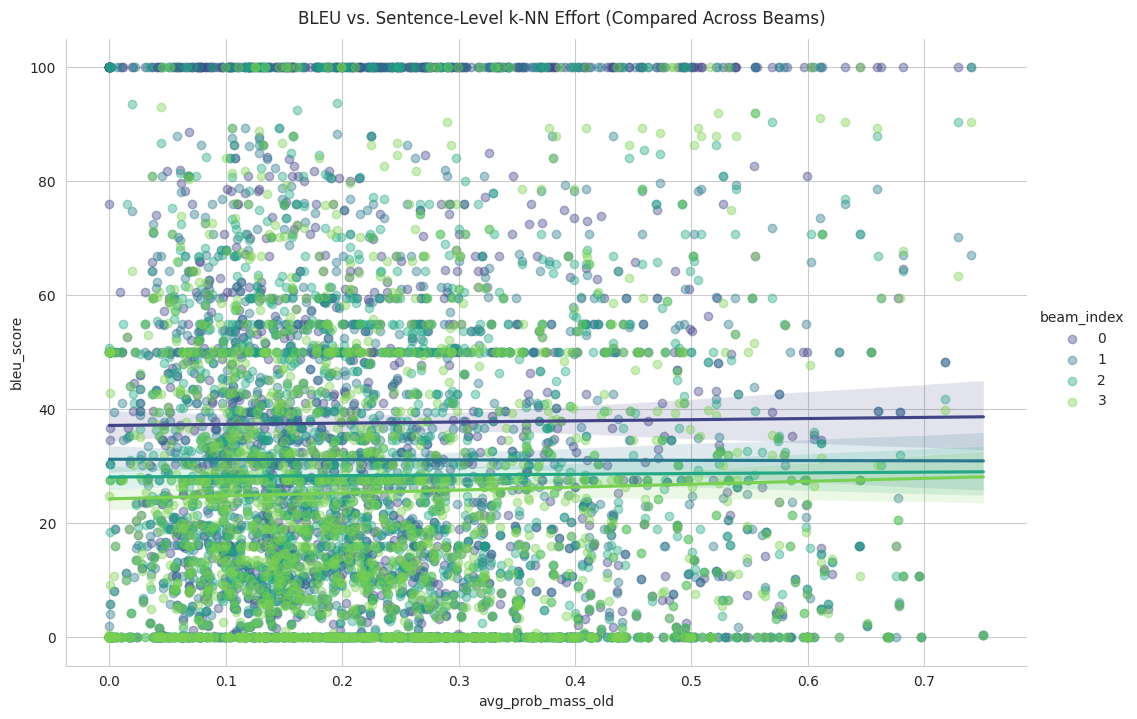


--- Analysis for Beam Hypothesis 0 ---


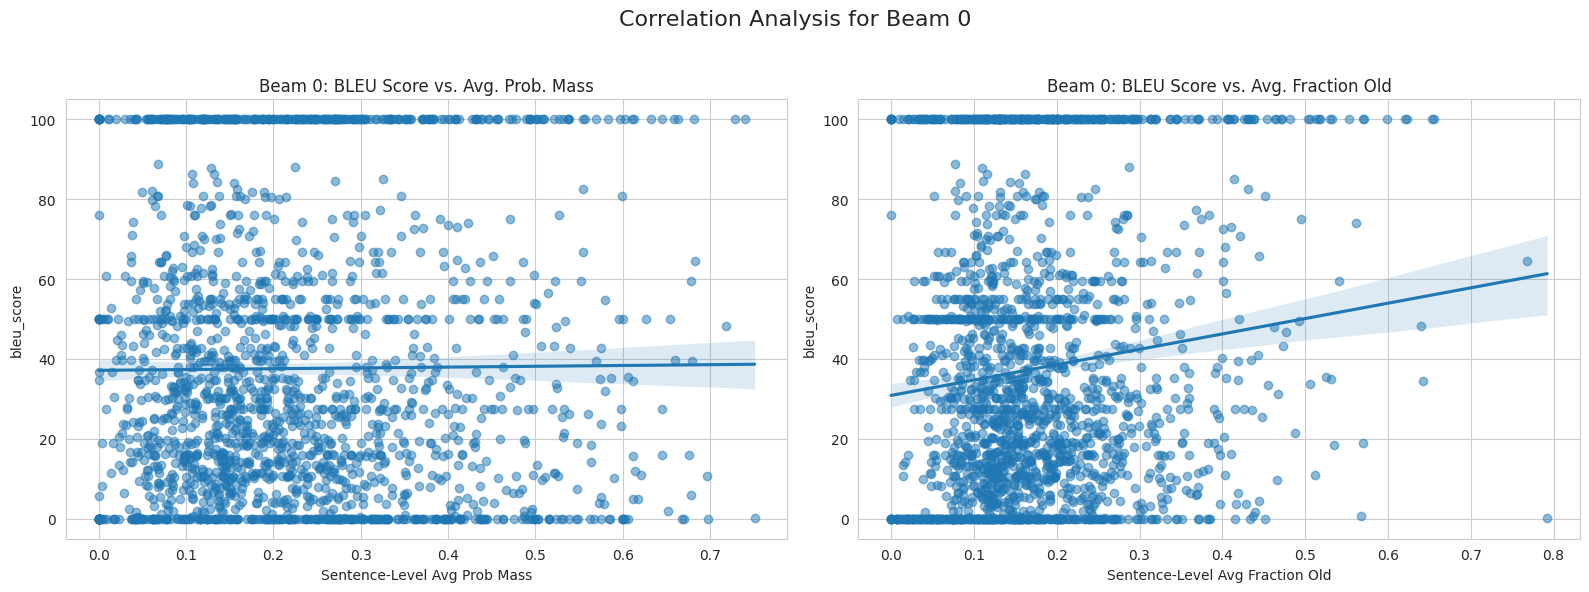


--- Analysis for Beam Hypothesis 1 ---


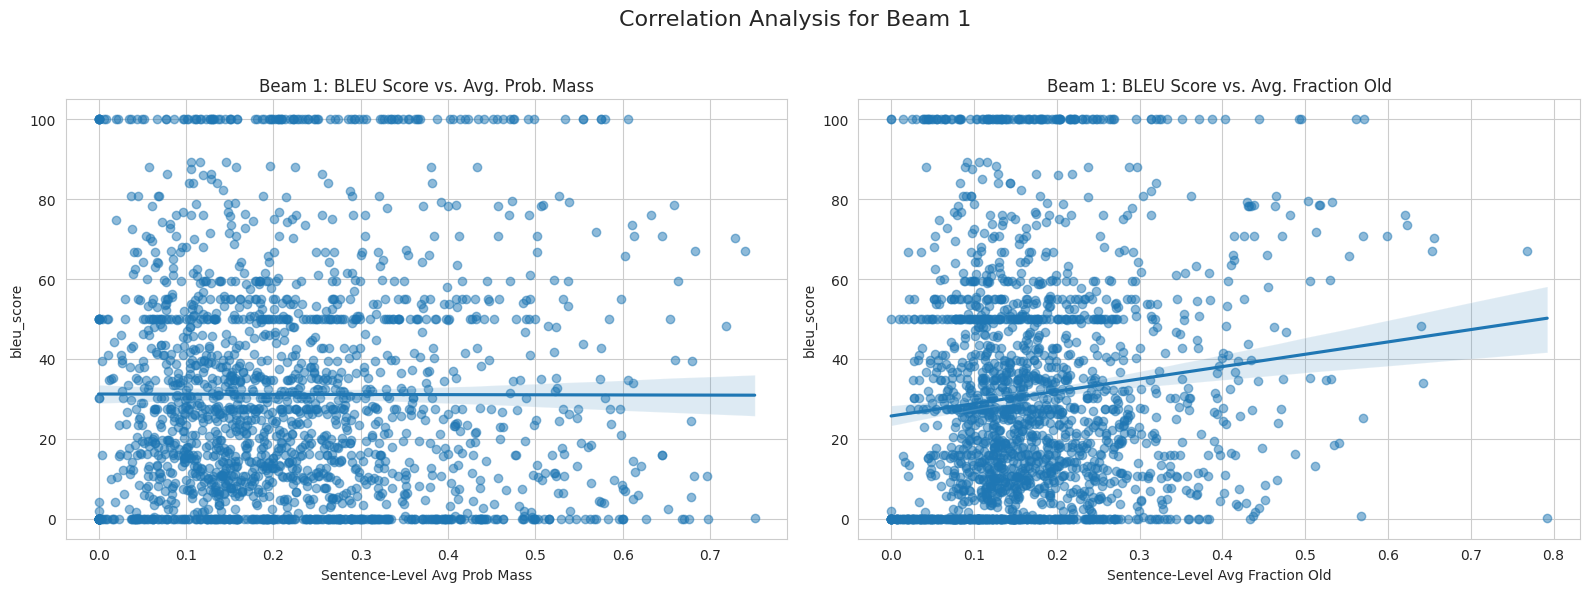


--- Analysis for Beam Hypothesis 2 ---


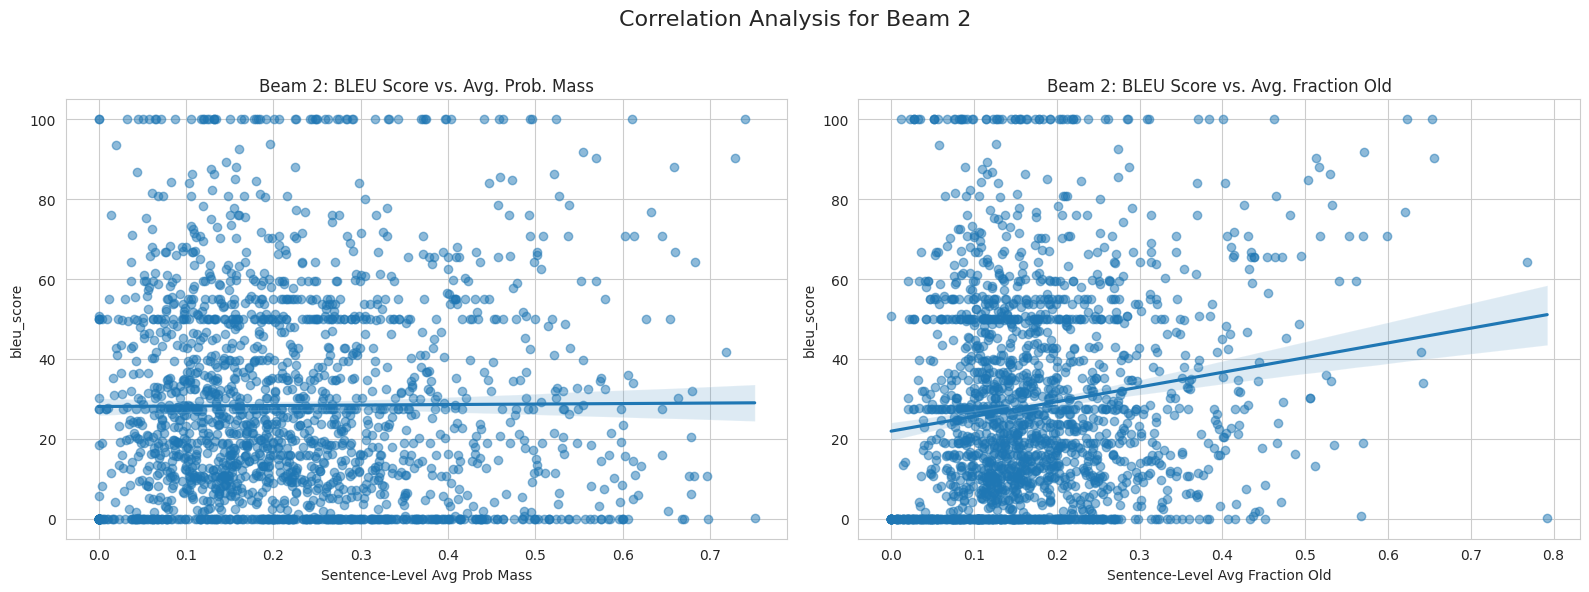


--- Analysis for Beam Hypothesis 3 ---


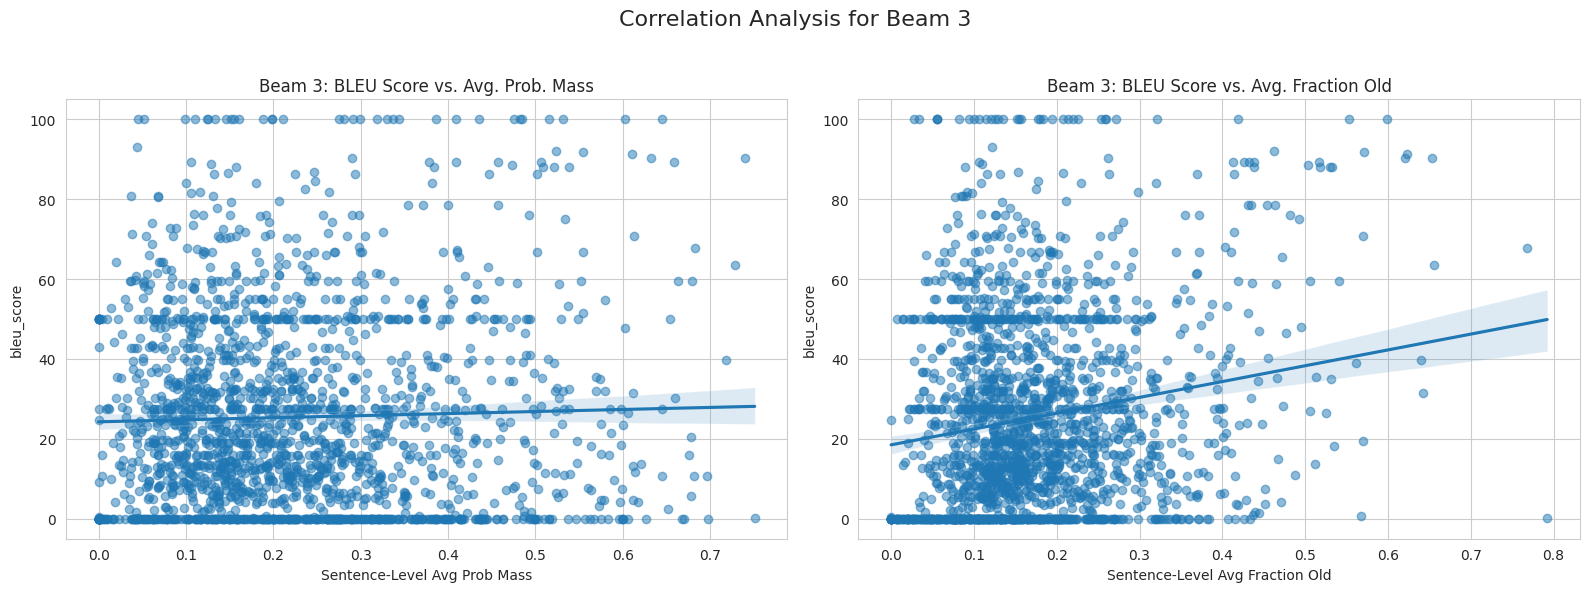

In [3]:
import re
import pandas as pd
import numpy as np
import sacrebleu
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import itertools

# --- Configuration ---
# --- IMPORTANT: Change this variable to your log file path ---
log_file_path = 'inference_output90_11.txt'
max_lines_to_read = None # Set to None to read the entire file

# --- Step 1: Parse All Data into Raw Structures ---
print("--- Step 1: Parsing Log File ---")

# These dicts will hold the raw parsed data
diag_stats_raw = defaultdict(lambda: {"fraction_old": [], "prob_mass_old": []})
translations_raw = defaultdict(lambda: {"ref": None, "hypos": []})

# Regex patterns
target_pattern = re.compile(r"^T-(\d+)\s(.*)")
hypo_pattern = re.compile(r"^D-(\d+)\s-?[\d.]+\s(.*)")
diag_pattern = re.compile(r"DIAG_SENT,(\d+),fraction_old=([\d.]+),prob_mass_old=([\d.]+)")

try:
    with open(log_file_path, 'r', encoding='utf-8') as f:
        line_iterator = itertools.islice(f, max_lines_to_read) if max_lines_to_read else f
        for line in line_iterator:
            clean_line = line.strip()

            diag_match = diag_pattern.match(clean_line)
            if diag_match:
                sent_id, frac, prob = diag_match.groups()
                diag_stats_raw[sent_id]["fraction_old"].append(float(frac))
                diag_stats_raw[sent_id]["prob_mass_old"].append(float(prob))
                continue

            target_match = target_pattern.match(clean_line)
            if target_match:
                sent_id, text = target_match.groups()
                translations_raw[sent_id]['ref'] = text
                continue

            hypo_match = hypo_pattern.match(clean_line)
            if hypo_match:
                sent_id, text = hypo_match.groups()
                translations_raw[sent_id]['hypos'].append(text)

except FileNotFoundError:
    print(f"Error: The file '{log_file_path}' was not found.")
    diag_stats_raw, translations_raw = {}, {}

print(f"Parsing complete. Found stats for {len(diag_stats_raw)} sentences and translations for {len(translations_raw)} sentences.")


# --- Step 2: Aggregate Diagnostic Stats at the Sentence Level ---
print("\n--- Step 2: Aggregating k-NN Stats per Sentence ---")
sentence_level_avg_stats = {}
for sent_id, data in diag_stats_raw.items():
    sentence_level_avg_stats[sent_id] = {
        'avg_fraction_old': np.mean(data['fraction_old']) if data['fraction_old'] else 0,
        'avg_prob_mass_old': np.mean(data['prob_mass_old']) if data['prob_mass_old'] else 0,
    }
print(f"Aggregated diagnostic stats for {len(sentence_level_avg_stats)} sentences.")


# --- Step 3: Combine Sentence-Level Stats with Per-Hypothesis Accuracy ---
print("\n--- Step 3: Assembling Final DataFrame ---")
flat_data = []
for sent_id, trans_data in translations_raw.items():
    # We need a reference, hypotheses, and diagnostic stats to proceed
    if trans_data['ref'] and trans_data['hypos'] and sent_id in sentence_level_avg_stats:
        ref_text = trans_data['ref']
        # Get the sentence-level average stats
        avg_stats = sentence_level_avg_stats[sent_id]

        for beam_index, hypo_text in enumerate(trans_data['hypos']):
            bleu = sacrebleu.sentence_bleu(hypo_text, [ref_text])

            record = {
                'sent_id': int(sent_id),
                'beam_index': beam_index,
                'bleu_score': bleu.score,
                'p4': bleu.precisions[3],
                # Assign the SAME sentence-level avg stats to each hypothesis
                'avg_fraction_old': avg_stats['avg_fraction_old'],
                'avg_prob_mass_old': avg_stats['avg_prob_mass_old'],
            }
            flat_data.append(record)

# Create the final DataFrame
df = pd.DataFrame(flat_data)
if not df.empty:
    print(f"Successfully created DataFrame with {len(df)} total hypotheses.")
    # Show how the avg stats are the same for all beams of a sentence
    print(df.head(8))
else:
    print("Could not create DataFrame. Check if log file contains all necessary data types (T, D, and DIAG_SENT lines).")


# --- Step 4: Full Per-Beam Analysis ---
if not df.empty:
    print("\n--- Step 4: Running Per-Beam Analysis ---")
    sns.set_style("whitegrid")

    # Combined plot to compare all beams
    g = sns.lmplot(data=df, x='avg_prob_mass_old', y='bleu_score', hue='beam_index',
                   height=7, aspect=1.5, palette='viridis', scatter_kws={'alpha': 0.4})
    g.fig.suptitle('BLEU vs. Sentence-Level k-NN Effort (Compared Across Beams)', y=1.02)
    plt.show()

    # Loop for detailed plots
    num_beams = df['beam_index'].max() + 1
    for i in range(num_beams):
        print(f"\n--- Analysis for Beam Hypothesis {i} ---")
        df_beam = df[df['beam_index'] == i].copy()

        if df_beam.empty:
            continue

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'Correlation Analysis for Beam {i}', fontsize=16)

        sns.regplot(ax=axes[0], data=df_beam, x="avg_prob_mass_old", y="bleu_score", scatter_kws={'alpha':0.5})
        axes[0].set_title(f"Beam {i}: BLEU Score vs. Avg. Prob. Mass")
        axes[0].set_xlabel("Sentence-Level Avg Prob Mass")

        sns.regplot(ax=axes[1], data=df_beam, x="avg_fraction_old", y="bleu_score", scatter_kws={'alpha':0.5})
        axes[1].set_title(f"Beam {i}: BLEU Score vs. Avg. Fraction Old")
        axes[1].set_xlabel("Sentence-Level Avg Fraction Old")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


--- Step 5: Binned Analysis for Beam Hypothesis 0 ---
--- Analysis Binned by Probability Mass for Beam 0 ---
  prob_mass_bin       mean  count        std
0  (-0.01, 0.0]  46.781894     23  47.880986
1    (0.0, 0.1]  35.873440    366  32.070413
2    (0.1, 0.2]  38.706264    621  31.275910
3    (0.2, 0.4]  37.094707    722  34.382940
4  (0.4, 0.761]  38.078817    268  36.585457


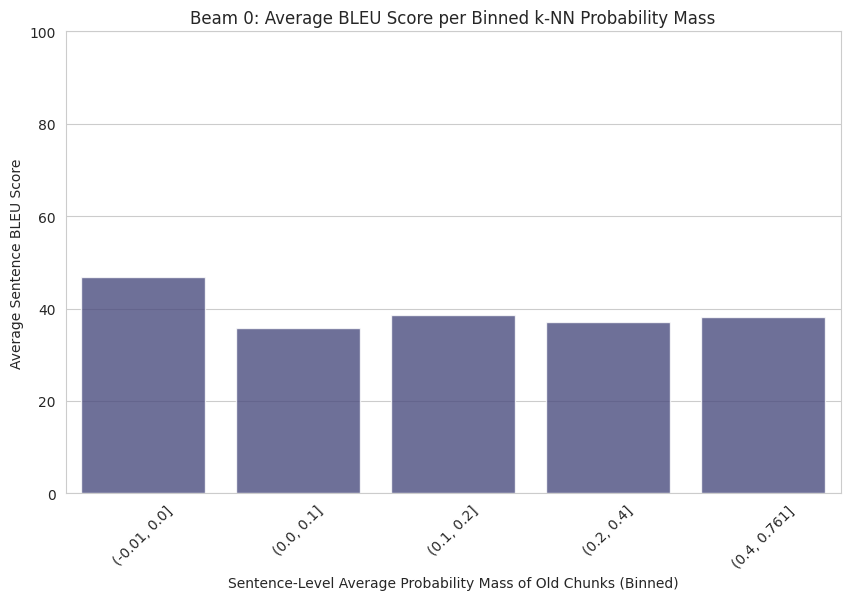


--- Step 5: Binned Analysis for Beam Hypothesis 1 ---
--- Analysis Binned by Probability Mass for Beam 1 ---
  prob_mass_bin       mean  count        std
0  (-0.01, 0.0]  17.474431     23  35.662862
1    (0.0, 0.1]  31.429385    366  27.065852
2    (0.1, 0.2]  31.482859    621  26.243391
3    (0.2, 0.4]  31.012504    722  28.090690
4  (0.4, 0.761]  31.445217    268  31.419179


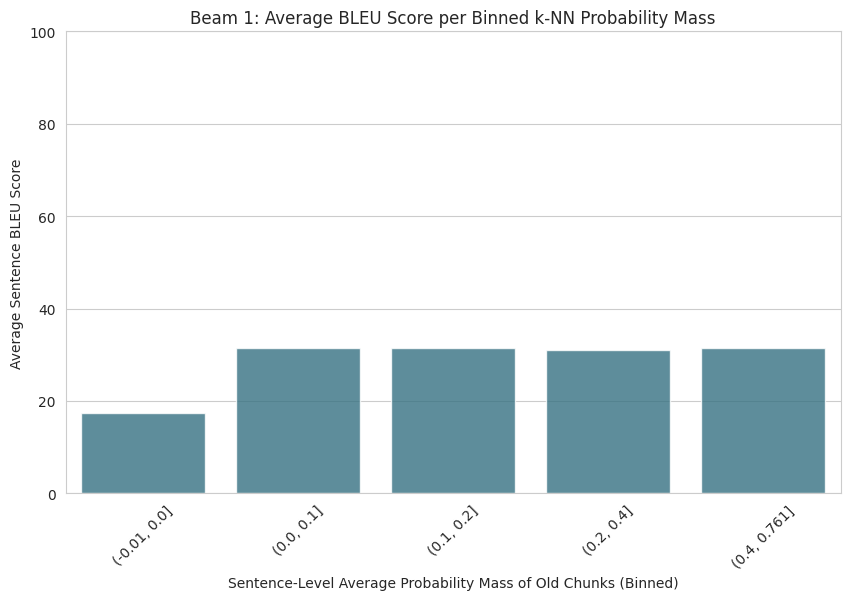


--- Step 5: Binned Analysis for Beam Hypothesis 2 ---
--- Analysis Binned by Probability Mass for Beam 2 ---
  prob_mass_bin       mean  count        std
0  (-0.01, 0.0]   2.209273     23  10.595300
1    (0.0, 0.1]  28.004343    366  24.435407
2    (0.1, 0.2]  30.665013    621  24.631846
3    (0.2, 0.4]  27.080326    722  25.427048
4  (0.4, 0.761]  29.332054    268  28.404601


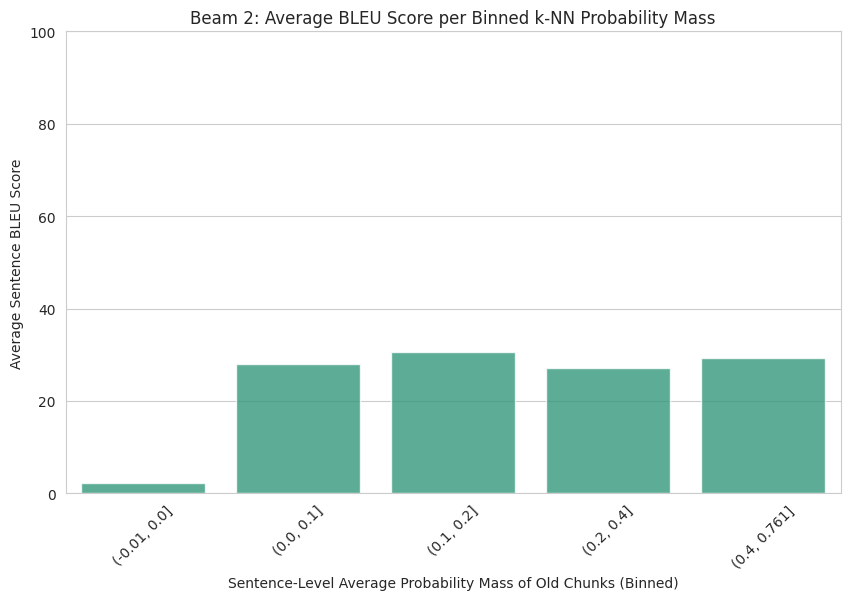


--- Step 5: Binned Analysis for Beam Hypothesis 3 ---
--- Analysis Binned by Probability Mass for Beam 3 ---
  prob_mass_bin       mean  count        std
0  (-0.01, 0.0]   7.621408     23  17.550252
1    (0.0, 0.1]  25.168380    366  21.926895
2    (0.1, 0.2]  27.039986    621  23.039200
3    (0.2, 0.4]  23.628938    722  23.104029
4  (0.4, 0.761]  28.491727    268  28.785633


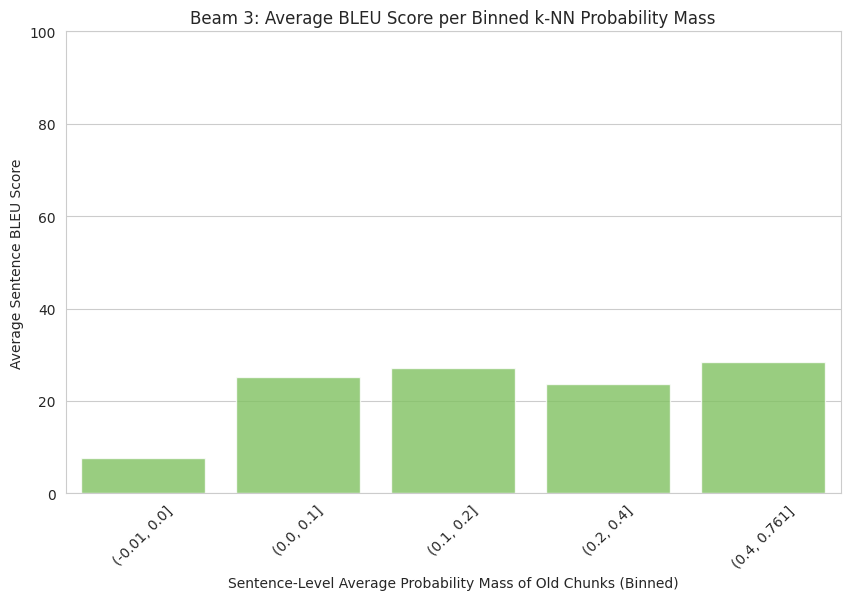

In [ ]:
if not df.empty:
    num_beams = df['beam_index'].max() + 1

    # Define a consistent color palette for the beams
    palette = sns.color_palette("viridis", n_colors=num_beams)

    for i in range(num_beams):
        print("\n" + "="*60)
        print(f"--- Step 5: Binned Analysis for Beam Hypothesis {i} ---")
        print("="*60)

        df_beam = df[df['beam_index'] == i].copy()

        if df_beam.empty:
            print(f"No data found for beam index {i}.")
            continue

        # 1. Create bins for 'avg_prob_mass_old' for the current beam's data
        # We add a small epsilon to the max to ensure it's included in the bin
        max_val = df_beam['avg_prob_mass_old'].max()
        prob_mass_bins = [-0.01, 0.0, 0.1, 0.2, 0.4, max_val + 0.01]
        df_beam['prob_mass_bin'] = pd.cut(df_beam['avg_prob_mass_old'], bins=prob_mass_bins, right=True)

        # 2. Group by these new bins and calculate the mean of the metrics
        binned_analysis = df_beam.groupby('prob_mass_bin')['bleu_score'].agg(['mean', 'count', 'std']).reset_index()

        print(f"--- Analysis Binned by Probability Mass for Beam {i} ---")
        print(binned_analysis)

        # 3. Visualize the result with a bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x='prob_mass_bin', y='mean', data=binned_analysis, color=palette[i], alpha=0.8)
        plt.title(f'Beam {i}: Average BLEU Score per Binned k-NN Probability Mass')
        plt.xlabel('Sentence-Level Average Probability Mass of Old Chunks (Binned)')
        plt.ylabel('Average Sentence BLEU Score')
        plt.xticks(rotation=45)
        plt.ylim(0, 100) # Keep y-axis consistent for easier comparison
        plt.show()
